# Adding Deep Learning to Tabular Models

Two blogs on the same day! I didn't want the last one to be too long and I didn't think I would be this productive to be able to finish the neural network part today. But, here we go.

---

Previously, I trained a random forest model for predicting sale price on past auction data for bulldozers. Today, I'm going to be training a deep learning model on the same data set (with some changes based on the [last blog](https://geon-youn.github.io/DunGeon/2022/03/31/Blue-Book.html)). Then, I'll try using the embeddings learned from that model and train another random forest model and aim for an even better validation RMSE. Finally, I'll ensemble the results of the deep learning model and the new random forest model and see how much better the predictions become. 

In [1]:
#hide
!pip install -Uqq fastbook
# required since March 30, 2022
!pip install tornado==5.1
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.4 MB/s 
     |████████████████████████████████| 49 kB 3.5 MB/s 
     |████████████████████████████████| 187 kB 10.0 MB/s 
     |████████████████████████████████| 1.2 MB 29.4 MB/s 
     |████████████████████████████████| 56 kB 2.3 MB/s 
     |████████████████████████████████| 51 kB 227 kB/s 
     |████████████████████████████████| 561 kB 36.4 MB/s 
     |████████████████████████████████| 130 kB 34.2 MB/s 
     |████████████████████████████████| 428 kB 33.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires tornado~=5.1.0; python_version >= "3.0", but you have tornado 6.1 which is incompatible.
     |████████████████████████████████| 516 kB 5.3 MB/s 
  Created wheel for tornado: filename=tornado-5.1-cp37-cp37m-linux_x86_64.whl size=462842 sha256=49a557ed19a583c15cbe1402b2ce48260dd1050

Mounted at /content/gdrive


In [3]:
#hide
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


In [6]:
#hide
%cd /content/gdrive/MyDrive/data_sets/bluebook/
%ls

/content/gdrive/MyDrive/data_sets/bluebook
 bluebook-for-bulldozers.zip        tp.pkl              Valid.csv
'Data Dictionary.xlsx'              Train.7z            ValidSolution.csv
 kaggle.json                        TrainAndValid.7z    valid_xs_fin.pkl
 Machine_Appendix.csv               TrainAndValid.csv   valid_xs_imp.pkl
 median_benchmark.csv               TrainAndValid.zip   valid_xs_new.pkl
 m.pkl                              train_xs_fin.pkl    Valid.zip
 random_forest_benchmark_test.csv   Train.zip           xs_imp.pkl
 Test.csv                           Valid.7z            xs_new.pkl


In [7]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

So, we'll first read our data into a pandas `DataFrame`,

In [56]:
df = pd.read_csv('TrainAndValid.csv', low_memory=False)

Then, we apply the initial transforms we did last time:
 - Set an order for the product sizes.
 - Log the sale price.
 - Split the date column into metacolumns.

In [57]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'] = df['ProductSize'].cat.set_categories(sizes, ordered=True)
df['SalePrice'] = np.log(df['SalePrice'])
df = add_datepart(df, 'saledate')

And we remove all the unneeded columns we determined last time:

In [58]:
#hide
# we need to do this before the next few cells
# since we don't need saleYear and saleMonth so
# they get removed
cond = (df['saleYear'] < 2011) | (df['saleMonth'] < 11)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]
splits = (list(train_idx), list(valid_idx))

In [59]:
to_keep_df = load_pickle('xs_new.pkl')

In [60]:
to_keep = list(to_keep_df) + ['SalePrice']

In [61]:
df = df[to_keep]
df.head(3)

,YearMade,ProductSize,Coupler_System,fiProductClassDesc,...,Drive_System,Hydraulics,Tire_Size,SalePrice
0,2004,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,...,NaN,2 Valve,None or Unspecified,11.097410
1,1996,Medium,NaN,Wheel Loader - 150.0 to 175.0 Horsepower,...,NaN,2 Valve,23.5,10.950807
2,2001,NaN,None or Unspecified,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,...,NaN,Auxiliary,NaN,9.210340


In [62]:
#hide
save_pickle('df.pkl', df)

In [63]:
#hide
df = load_pickle('df.pkl')

In [64]:
#hide
# these are the functions we defined in the last blog
def r_mse(preds, y):
    return round(math.sqrt(((preds - y)**2).mean()), 6)
    
def m_rmse(m, xs, y):
    return r_mse(m.predict(xs), y)

def rf(xs, y, n_estimators = 40, max_samples = 200_000, 
       max_features = 0.5, min_samples_leaf = 5, **kwargs):
    return RandomForestRegressor(
        n_jobs       = -1,                   # use all CPU cores
        n_estimators = n_estimators,         # number of decision trees
        max_samples  = max_samples,          # max number of rows to get
        max_features = max_features,         # how many columns to get (%)
        min_samples_leaf = min_samples_leaf, # leaf nodes must have at least this many (to prevent overfitting)
        oob_score    = True                  # track out-of-box error score
    ).fit(xs, y)

def feature_importance(df, m):
    return pd.DataFrame({'Feature': df.columns, 'Importance': m.feature_importances_}).sort_values('Importance', ascending = False)

def get_oob(df):
    m = RandomForestRegressor(
        n_estimators = 40, 
        min_samples_leaf = 15, # higher to have a shorter depth tree
        max_samples = 50_000,
        max_features = 0.5,
        n_jobs = -1,
        oob_score = True).fit(df, train_y)
    return m.oob_score_

Next, we have to know which columns should be treated as categorical so that they can be given embeddings. For that, we'll use `cont_cat_split`, but we set the max cardinality as 9000 (embedding sizes greater than 10,000 should be used after you tested if there's better ways to group the variable).

In [65]:
cont, cat = cont_cat_split(df, max_card=9_000, dep_var='SalePrice')

Mainly, we want to ensure `saleElapsed` is in the continuous section since by definition, if a label is in the categorical section, it cannot be extrapolated.

In [66]:
cont

['saleElapsed']

Next, let's see the cardinality of each of the categorical variables (if there's some that are similar in number, they may be redundant and we can try to remove all but one):

In [67]:
df[cat].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Enclosure                6
fiModelDesc           5059
ProductGroupDesc         6
fiModelDescriptor      140
Drive_System             4
Hydraulics              12
Tire_Size               17
dtype: int64

It appears that `ModelID` and `fiModelDesc` may be redundant since they're both pertaining to `Model` and are of similar cardinality. So, we'll do what we did before and try removing `fiModelDesc` and see what happens to the results. 

In [68]:
#hide
tp           = load_pickle('tp.pkl')
xs_new       = load_pickle('xs_new.pkl') 
valid_xs_new = load_pickle('valid_xs_new.pkl')
train_y, valid_y = tp.train.y, tp.valid.y

In [69]:
get_oob(xs_new)

0.8760441852100622

In [70]:
{c: get_oob(xs_new.drop(c, axis=1)) for c in 
 ['ModelID', 'fiModelDesc', 'fiModelDescriptor']}

{'ModelID': 0.8717292042012881,
 'fiModelDesc': 0.869256405033346,
 'fiModelDescriptor': 0.8748457618690582}

Overall, it seems we can remove `fiModelDescriptor` without it significantly affecting the model.

In [71]:
cat.remove('fiModelDescriptor')

To create `DataLoaders` for our model, we can use `TabularPandas` again. However, we have to add the `Normalize` `TabularProc` for a neural network since the scale of the variables matter unlike in building a decision tree. 

In [73]:
tp = TabularPandas(df, [Categorify, FillMissing, Normalize],
                   cat, cont, splits=splits, y_names='SalePrice')

In [74]:
# we can use a larger batch size compared to
# a vision model since we're dealing with
# dabular data (doesn't require as much GPU RAM)
dls = tp.dataloaders(1024)

Next, we'll see what range we should have for our predictions.

In [79]:
y, v_y = tp.train.y, tp.valid.y
y.min(),y.max(),v_y.min(),v_y.max()

(8.465899467468262, 11.863582611083984, 8.465899467468262, 11.849397659301758)

So, we can set our `y_range` as (8, 12) (remember that a model tends to do better when we have our upper bound a little higher than the actual maximum).  

In [82]:
learn = tabular_learner(dls, layers=[500, 250], 
                        y_range=(8, 12), n_out=1,
                        loss_func=F.mse_loss)

As always, we'll use `.lr_find()` to find the optimal learning rate:

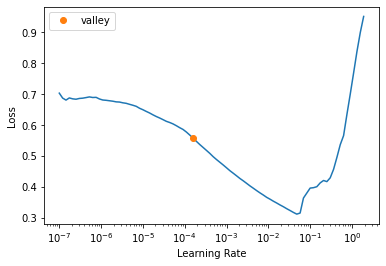

In [83]:
lr = learn.lr_find().valley

And, we'll use `fit_one_cycle` to train our model since we're not transfer learning:

In [86]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,0.068500,0.075998,00:07
1,0.052604,0.063197,00:07
2,0.047209,0.059763,00:07
3,0.043221,0.061487,00:07
4,0.039401,0.053084,00:07


In [90]:
preds, targs = learn.get_preds()
r_mse(preds, targs)

0.230399

Overall, we got a better RMSE than the random forest model, but not by a lot. 

In [91]:
#hide
save_pickle('learn.pkl', learn)

In [ ]:
#hide
learn = load_pickle('learn.pkl')

Now, we'll try using the embeddings from the neural network to replace the categorical columns for our random forest:

In [147]:
# code is essentially verbatim from fast.ai's @danielwbn:
# https://forums.fast.ai/t/using-embedding-from-the-neural-network-in-random-forests/80063/10
def transfer_embeds(learn, xs):
    xs = xs.copy()
    for i, feature in enumerate(learn.dls.cat_names):
        emb = learn.embeds[i].cpu() 
        # added .cpu() to learn since tensor below is made on cpu while learn is on cuda
        new_feat = pd.DataFrame(emb(tensor(xs[feature], dtype=torch.int64)),
                                index=xs.index, 
                                columns=[f'{feature}_{j}' for j in range(emb.embedding_dim)])
        xs = xs.drop(feature, axis=1)
        xs = xs.join(new_feat)
    return xs

In [148]:
xs_with_embs       = transfer_embeds(learn, learn.dls.train.xs) 
valid_xs_with_embs = transfer_embeds(learn, learn.dls.valid.xs)

In [150]:
#hide
xs_with_embs

,saleElapsed,YearMade_0,YearMade_1,YearMade_2,...,Tire_Size_4,Tire_Size_5,Tire_Size_6,Tire_Size_7
0,0.374363,-0.006804,0.025413,0.022735,...,0.003835,-0.004636,-0.001658,0.010026
1,-0.081862,0.021130,0.017134,-0.012756,...,0.014869,0.009283,-0.006036,-0.001544
2,-0.095572,0.014606,-0.009932,-0.006298,...,-0.012436,-0.007393,-0.013705,0.001535
3,1.152073,0.014606,-0.009932,-0.006298,...,-0.012436,-0.007393,-0.013705,0.001535
4,0.837680,-0.023084,0.009760,0.038636,...,-0.012436,-0.007393,-0.013705,0.001535
...,...,...,...,...,...,...,...,...,...
412693,1.290595,-0.010673,0.019795,0.006931,...,-0.012436,-0.007393,-0.013705,0.001535
412694,1.272157,-0.010673,0.019795,0.006931,...,-0.012436,-0.007393,-0.013705,0.001535
412695,1.272157,-0.010673,0.019795,0.006931,...,-0.012436,-0.007393,-0.013705,0.001535
412696,1.290595,-0.015706,0.004882,0.017343,...,-0.012436,-0.007393,-0.013705,0.001535


In [151]:
m = rf(xs_with_embs, train_y)

In [152]:
#hide
save_pickle('m_embs.pkl', m)

In [ ]:
#hide
m = load_pickle('m_embs.pkl')

In [154]:
m_rmse(m, xs_with_embs, train_y), m_rmse(m, valid_xs_with_embs, valid_y)

(0.184022, 0.236021)

The validation RMSE ends up becoming worse! But, take a look at this:

We'll look at our RMSE when we ensemble the predictions from random forests (with embeddings) and the neural network. However, before we can take the average of the predictions from random forests and the neural network, we have to make them of the same type. To do so, we have to turn our neural network predictions (a rank-2 tensor) into a rank-1 numpy array. We can apply `.squeeze()` to remove any unit axis (a vector with only 1 thing in it)

In [155]:
rf_preds = m.predict(valid_xs_with_embs)
ens_preds = (to_np(preds.squeeze()) + rf_preds) / 2

In [156]:
r_mse(ens_preds, valid_y)

0.228773

And, we now have an RMSE that's lower than the top leaderboard score of 0.22909, granted we're doing it on the validation set (since we don't have access to the `SalePrice` of `Test.csv`):

In [162]:
a = pd.read_csv('Test.csv', low_memory=False)
a.columns, 'SalePrice' in a.columns

(Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
        'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'saledate',
        'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
        'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
        'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
        'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
        'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
        'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
        'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
        'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
        'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
        'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
        'Differential_Type', 'Steering_Controls'],
       dtype='object'), False)

So, we've finally covered tabular data training with decision trees, random forests, neural networks, and random forests with embeddings. We've ensembled the results of the last 2 to get a score that ("technically") beats the top leaderboard score of the Kaggle competition. 

Next, we'll be moving onto natural language models. But, I might also try experimenting with another tabular data set. 